# **MLP on the MNIST Dataset** 


# 1. Importing Libraries

In [496]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import time

In [497]:
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.utils import np_utils
from keras.initializers import RandomNormal
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import adam_v2 as Adam
from keras.optimizers import rmsprop_v2 as RMSprop
from keras import backend as k
from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.layers.core import Lambda, Flatten
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Convolution2D , MaxPooling2D

# 2. Loading the Dataset

In [498]:
# importing the dataset
from keras.datasets import mnist

In [499]:
# loading the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

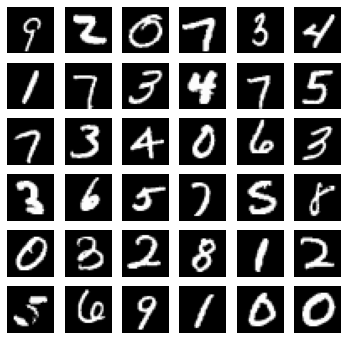

In [500]:
# picking 36 random images/numbers from X_train and y_train
indexes = np.random.randint(0, X_train.shape[0], size=36)
images = X_train[indexes]
labels = y_train[indexes]


# plotting 36 mnist digits
plt.figure(figsize=(6,6))
for i in range(len(indexes)):
    plt.subplot(6, 6, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
plt.show()
plt.savefig("mnist-samples.png")
plt.close('all')

In [501]:
X_train.shape

(60000, 28, 28)

In [502]:
# counting the number of unique training labels
unique, counts = np.unique(y_train, return_counts = True)
print("Unique train labels: ", dict(zip(unique, counts)))

Unique train labels:  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


In [503]:
# counting the unique number of test labels
unique, counts = np.unique(y_test, return_counts = True)
print("Unique test labels: ", dict(zip(unique, counts)))

Unique test labels:  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


Plot function
-> can be used to make plots for each epoch and error

In [504]:
%matplotlib notebook
def plt_dynamic(x, vy, ty, ax, colors = ['b']):
  ax.plot(x, vy, 'b', label = "Validation loss")
  ax.plot(y, ty, 'r', label = "Training loss")
  plt.legend()
  plt.show()
  fig.canvas.draw()

Reshaping (after making a copy) the 28*28 pixelated image to a single vector with 784 elements before we input the raw data to the neural net

In [505]:
X_train_copy = X_train
X_test_copy = X_test

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

In [506]:
print("Number of training datapoints are:", X_train.shape[0], ", and each image after vectorizing is of the shape:", X_train.shape[1])
print("Number of testing datapoints are:", X_test.shape[0], ", and each image after vectorizing is of the shape:", X_test.shape[1])

Number of training datapoints are: 60000 , and each image after vectorizing is of the shape: 784
Number of testing datapoints are: 10000 , and each image after vectorizing is of the shape: 784


The image is now converted into a matrix with 28*28 elements where each element in the matrix is between 0 and 256 depending on the intensity of darkness in that pixel

In [507]:
# Example of a datapoint/image
print(X_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247 241   0   0   0   0   

Converting the images to grayscale

In [508]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

Normalizing this grayscale data in a 28*28 pixelated image from 0 to 1 (0 for white and 1 for black)

In [509]:
X_train = X_train/255
X_test = X_test/255

In [510]:
print(X_train[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

Labelling/One-Hot Encoding the Output numbers into a vector matrix

In [511]:
print("The first image's actual number is:", y_train[0])

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

print("The actual output number after one hot encoding is:", y_train[0])

The first image's actual number is: 5.0
The actual output number after one hot encoding is: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# 3. Building Models

We can use a sequential model because this model doesn't have multiple inputs or outputs, and neither do any of the layers

In [512]:
X_test_label = X_test.astype('int32')
y_test_label = y_test.astype('int32')

Defining a function for a new model

In [513]:
def create_model(input_length, hidden_lenght1, hidden_lenght2, activation_func, dropout_val,lr_val,num_epochs, batch_size):

    # training the model and saving metrics in history
    model = Sequential()

    model.add(Dense(hidden_lenght1, input_dim=input_length, activation=activation_func))
    model.add(Dropout(dropout_val))

    model.add(Dense(hidden_lenght2, activation=activation_func))
    model.add(Dropout(dropout_val))
    model.add(Dense(10, activation='softmax'))

    lr = lr_val # 0.001 learning rate
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    filepath = 'tmp_weights.best.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    # training the model and saving metrics in history
    history_model = model.fit(X_train, y_train, callbacks=callbacks_list,
                              epochs=num_epochs, batch_size=batch_size, verbose=2,
                                validation_data = (X_test, y_test))  # verbose 2 or 0 
    return model, history_model

In [514]:
def saving_the_model(model, model_name = 'model_history.h5'):  
    model.save(model_name)
    print('Saved trained model at %s ' % model_name)

In [515]:
def draw_model(training):
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(training.history['accuracy'])
    plt.plot(training.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend(['train', 'test'], loc='lower right')
    plt.subplot(2,1,2)
    plt.plot(training.history['loss'])
    plt.plot(training.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train', 'test'], loc='upper right')
    plt.tight_layout()
    plt.show()

In [516]:
# evaluate test accuracy
def scoring_the_model(model_name="model_history.h5"):
    # load the model and create predictions on the test set
    mnist_model = load_model(model_name)
    #1- genel bakış
    loss_and_metrics = mnist_model.evaluate(X_test, y_test, verbose=2)
    print("Test Loss", loss_and_metrics[0])
    print("Test Accuracy", loss_and_metrics[1])

    #2- test sonrası
    predicted_classes = mnist_model.predict(X_test) 
    classes_x=np.argmax(predicted_classes,axis=1)
    # see which we predicted correctly and which not
    correct_indices = np.nonzero(predicted_classes == y_test_label)[0]
    incorrect_indices = np.nonzero(predicted_classes != y_test_label)[0]
    print()
    

def draw_9_correct_9_incorrect_predictions(model_name="model_history.h5"):  
    # load the model and create predictions on the test set
    mnist_model = load_model(model_name) 
    predicted_classes = mnist_model.predict(X_test) 
    classes_x=np.argmax(predicted_classes,axis=1)
    correct_indices = np.nonzero(predicted_classes == y_test_label)[0]
    incorrect_indices = np.nonzero(predicted_classes != y_test_label)[0]
    # adapt figure size to accomodate 18 subplots
    plt.rcParams['figure.figsize'] = (7,14)

    plt.figure()
    print("plot 9 correct predictions")
    # plot 9 correct predictions
    for i, correct in enumerate(correct_indices[:9]):
        plt.subplot(6,3,i+1)
        plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
        plt.title(
          "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                            y_test_label[correct]))
        plt.xticks([])
        plt.yticks([])

    print("plot 9 incorrect predictions")
    for i, incorrect in enumerate(incorrect_indices[:9]):
        plt.subplot(6,3,i+10)
        plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
        plt.title(
          "Predicted {}, Truth: {}".format(predicted_classes[incorrect],
                                           y_test_label[incorrect]))
        plt.xticks([])
        plt.yticks([])

In [ ]:
#parameters
#lengh_features = input layer = 28 pixel  * 28 pixel == 784 nodes

# Create Model1 # 784-128-128-10 Dropout 0.2,Learning Rate==0.001,Activation Function =relu
# hidden layer start 128 and 2 hidden layer
# activation relu for popular and fast
model1, history_model1 = create_model(input_length=784,hidden_lenght1=128,hidden_lenght2=128, activation_func='relu',dropout_val=0.20, lr_val=0.001,num_epochs=20, batch_size=128)
# saving the model
saving_the_model(model1,'model1_history.h5')


Epoch 1/20
469/469 - 3s - loss: 0.3813 - accuracy: 0.8868 - val_loss: 0.1602 - val_accuracy: 0.9502
Epoch 2/20


In [ ]:
# scoring the model
scoring_the_model('model1_history.h5')

In [ ]:
draw_model(history_model1)

In [ ]:
#parameters
#lengh_features = input layer = 28 pixel  * 28 pixel == 784 nodes

# Create Model1 # 784-128-128-10 Dropout 0.2,Learning Rate==0.001,Activation Function =sigmoid
# hidden layer start 128 and 2 hidden layer
# activation relu for popular and fast
model2, history_model2 = create_model(input_length=784,hidden_lenght1=128,hidden_lenght2=128, activation_func='sigmoid',dropout_val=0.20, lr_val=0.001,num_epochs=20, batch_size=128)
# saving the model
saving_the_model(model2,'model2_history.h5')

In [ ]:
# scoring the model
scoring_the_model('model2_history.h5')

In [ ]:
draw_model(history_model2)

In [493]:
#parameters
#lengh_features = input layer = 28 pixel  * 28 pixel == 784 nodes

# Create Model1 # 784-128-128-10 Dropout 0.2,Learning Rate==0.001,Activation Function =softmax
# hidden layer start 128 and 2 hidden layer
# activation relu for popular and fast
model3, history_model3 = create_model(input_length=784,hidden_lenght1=128,hidden_lenght2=128, activation_func='softmax',dropout_val=0.20, lr_val=0.001,num_epochs=20, batch_size=128)
# saving the model
saving_the_model(model3,'model3_history.h5')

Epoch 1/20
469/469 - 3s - loss: 2.2623 - accuracy: 0.2474 - val_loss: 2.1847 - val_accuracy: 0.6380
Epoch 2/20
469/469 - 3s - loss: 2.0456 - accuracy: 0.5788 - val_loss: 1.8460 - val_accuracy: 0.7453
Epoch 3/20
469/469 - 3s - loss: 1.7080 - accuracy: 0.6249 - val_loss: 1.4259 - val_accuracy: 0.7618
Epoch 4/20
469/469 - 2s - loss: 1.3962 - accuracy: 0.6310 - val_loss: 1.0607 - val_accuracy: 0.7684
Epoch 5/20
469/469 - 2s - loss: 1.1771 - accuracy: 0.6340 - val_loss: 0.8196 - val_accuracy: 0.7688
Epoch 6/20
469/469 - 2s - loss: 1.0440 - accuracy: 0.6393 - val_loss: 0.6862 - val_accuracy: 0.7747
Epoch 7/20
469/469 - 2s - loss: 0.9829 - accuracy: 0.6387 - val_loss: 0.6156 - val_accuracy: 0.7988
Epoch 8/20
469/469 - 2s - loss: 0.9415 - accuracy: 0.6455 - val_loss: 0.5756 - val_accuracy: 0.7940
Epoch 9/20
469/469 - 2s - loss: 0.9126 - accuracy: 0.6528 - val_loss: 0.5515 - val_accuracy: 0.7961
Epoch 10/20
469/469 - 3s - loss: 0.8934 - accuracy: 0.6599 - val_loss: 0.5317 - val_accuracy: 0.8184

In [494]:
# scoring the model
scoring_the_model('model3_history.h5')

313/313 - 0s - loss: 0.3146 - accuracy: 0.9195
Test Loss 0.3145638704299927
Test Accuracy 0.9194999933242798



In [495]:
draw_model(history_model3)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>